In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [6]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [246]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [259]:
# '''
#     synthetic_inst1: generated instance used with global model
#     synthetic_inst2: generated instance used with local model
#     global_model, local_model: any sklearn ML model or ML model that is extended from ML model
# '''
# def cal_bal_acc(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([True, False]):
#         local_pred = np.round(local_pred)
#         local_pred = [True if val else False for val in local_pred]
        
#     bal_acc = balanced_accuracy_score(global_pred, local_pred)
#     return bal_acc
    

def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

#     ret = False
    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
#     for tok in splitted_rule:
#         if tok.strip() in top_k_global_features:
#             found_features.append(tok)
#             ret = True
#             break
#             local_feature_count = local_feature_count+1
#     local_feature_ratio = local_feature_count/len(splitted_rule)
#     return ret
#     return local_feature_ratio
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    
def rq1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'.csv',index=False)
    print('finished RQ1 of',proj_name)
    
    
def rq2_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
        py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
        lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
        lime_exp_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_exp_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'.csv',index=False)
    print('finished RQ2 of',proj_name)


def eval_rule(rule, x_df):
    var_in_rule = re.findall('[a-zA-Z]+', rule)
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            if var in col:
                var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
#     print('Rulefit')
    py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
#     print('LIME')
    lime_all_eval_result = eval_rule(lime_rule_str, x_df)

#     print(py_exp_rule_str)
#     print(lime_rule_str)
    
#     tmp_df = x_df.copy()
#     tmp_df['ground_truth'] = ground_truth
#     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
#     display(tmp_df_clean)
    
    py_exp_result_df = pd.DataFrame()
    py_exp_result_df['ground_truth'] = ground_truth
    py_exp_result_df['rule_result'] = py_exp_all_eval_result
    py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
#     print(len(py_exp_result_df))
    # find ratio of clean commit
    py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
    lime_result_df = pd.DataFrame()
    lime_result_df['ground_truth'] = ground_truth
    lime_result_df['rule_result'] = lime_all_eval_result
    
#     display(x_df[x_df['la']>58])
    
    lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
#     print(len(lime_result_df))
    
    # find ratio of clean commit
    lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
#     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
#     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
    return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio


def rq3_rq4_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    rq3_eval_result = pd.DataFrame() # for train data
    rq4_eval_result = pd.DataFrame() # for test data
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
#         print(py_exp_the_best_defective_rule_str)
        
        lime_exp_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
#         print(lime_exp_the_best_defective_rule_str)
        lime_exp_the_best_defective_rule_str = flip_rule(lime_exp_the_best_defective_rule_str)
#         print(lime_exp_the_best_defective_rule_str)
        
        py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                lime_exp_the_best_defective_rule_str,
                                                                                x_train, y_train)
            
        py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                        lime_exp_the_best_defective_rule_str,
                                                                                        x_test, y_test)
        
#         print('train:',py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
#         print('test:',py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)
        py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
        lime_exp_serie_train = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_train])
        
        py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_test])
        lime_exp_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_test])
        
        rq3_eval_result = rq3_eval_result.append(py_exp_serie_train,ignore_index=True)
        rq3_eval_result = rq3_eval_result.append(lime_exp_serie_train, ignore_index=True)
        
        rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
#         break
#         print('pyExp rule:',py_exp_the_best_defective_rule_str)
#         print('lime rule:',lime_exp_the_best_defective_rule_str)
#         print(py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
#         print(py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
#         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    rq4_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'_new.csv',index=False)
    rq4_eval_result.to_csv(result_dir+'RQ4_'+proj_name+'_new.csv',index=False)
    print('finished RQ3 and RQ4 of',proj_name)


In [261]:
start = time.time()
rq3_rq4_eval('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
rq3_rq4_eval('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 co

In [ ]:
# rq1_eval('openstack')
# rq1_eval('qt')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,331.704115,0.431452
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,547.648247,0.050800
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,488.590016,0.689435
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1384.777800,0.049000
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,233.747669,0.463710


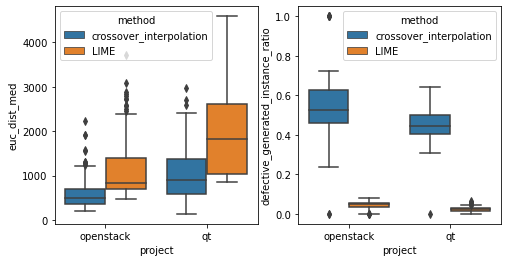

In [147]:
openstack_result_df = pd.read_csv('./eval_result/RQ1_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ1_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,2, figsize=(8,4))

sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1])
plt.show()

In [151]:
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

openstack result


euc_dist_med                                       \
                               count         mean         std         min   
method                                                                      
LIME                           198.0  1126.993520  623.744796  478.122694   
crossover_interpolation        198.0   590.215781  337.090202  203.839673   

                                                                           \
                                25%         50%          75%          max   
method                                                                      
LIME                     707.911839  839.004043  1406.863950  3714.300936   
crossover_interpolation  363.359087  487.382627   705.485094  2222.543551   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                 198.0  0.044074   
crossover_interpolation                              198.0  0.544319   

                                                                             
                              std  min      25%       50%       75%     max  
method                                                                       
LIME                     0.017399  0.0  0.03355  0.050000  0.055600  0.0802  
crossover_interpolation  0.137944  0.0  0.45786  0.528195  0.624881  1.0000

qt result


euc_dist_med                                       \
                               count         mean         std         min   
method                                                                      
LIME                            79.0  1979.342782  993.311405  856.917999   
crossover_interpolation         79.0  1071.828395  660.068370  140.197536   

                                                                             \
                                 25%          50%          75%          max   
method                                                                        
LIME                     1039.673910  1824.515489  2602.748286  4582.471964   
crossover_interpolation   583.644616   911.998473  1376.061356  2974.539252   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                  79.0  0.022592   
crossover_interpolation                               79.0  0.452475   

                                                                               
                              std  min      25%       50%       75%       max  
method                                                                         
LIME                     0.013654  0.0  0.01600  0.023400  0.027700  0.065400  
crossover_interpolation  0.087663  0.0  0.40478  0.443548  0.500436  0.639746

In [58]:
# eval_local_model('openstack')
# rq2_eval('openstack')
# rq2_eval('qt')

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.935895,0.986777,0.933446,0.874022
...,...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.593470,0.766139,0.316354,0.287202
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.953989,0.993379,0.941732,0.922158
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.582851,0.755158,0.288425,0.278623
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.952267,0.991391,0.946396,0.904913


finished RQ2 of openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.942295,0.990326,0.932782,0.886589
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.545853,0.729363,0.173228,0.219584
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.995112,0.999913,0.994624,0.990225
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.535057,0.707875,0.138114,0.183357
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.946433,0.992387,0.940270,0.895406
...,...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.506477,0.711098,0.031609,0.061353
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.549680,0.691682,0.185366,0.240080
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.943277,0.989941,0.935515,0.889176


finished RQ2 of qt


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.935895,0.986777,0.933446,0.874022


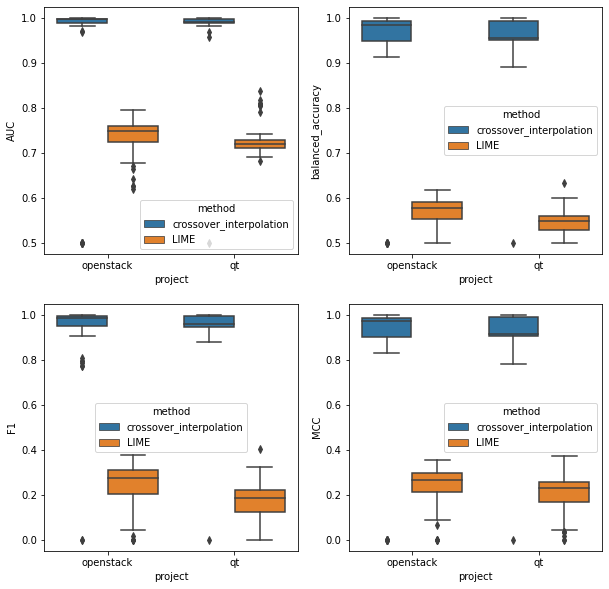

In [153]:
openstack_result_df = pd.read_csv('./eval_result/RQ2_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ2_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

In [159]:
pd.set_option("max_columns", 40)
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

openstack result


balanced_accuracy                                     \
                                    count      mean       std  min       25%   
method                                                                         
LIME                                198.0  0.570394  0.027628  0.5  0.552933   
crossover_interpolation             198.0  0.954411  0.096192  0.5  0.949023   

                                                         AUC            \
                              50%       75%       max  count      mean   
method                                                                   
LIME                     0.578235  0.591473  0.618989  198.0  0.739656   
crossover_interpolation  0.985273  0.993522  1.000000  198.0  0.975125   

                                                                           \
                              std       min       25%       50%       75%   
method                                                                      
LIME                     0.030157  0.620103  0.723966  0.749075  0.759501   
crossover_interpolation  0.097901  0.500000  0.989653  0.999018  0.999794   

                                      F1                                     \
                              max  count      mean       std  min       25%   
method                                                                        
LIME                     0.796816  198.0  0.248266  0.086481  0.0  0.202650   
crossover_interpolation  1.000000  198.0  0.958855  0.105003  0.0  0.951318   

                                                         MCC            \
                              50%       75%       max  count      mean   
method                                                                   
LIME                     0.276290  0.311654  0.378698  198.0  0.248051   
crossover_interpolation  0.987052  0.994695  1.000000  198.0  0.910063   

                                                                                
                              std  min       25%       50%       75%       max  
method                                                                          
LIME                     0.067190  0.0  0.211879  0.266913  0.296950  0.352627  
crossover_interpolation  0.192529  0.0  0.899902  0.972633  0.987274  1.000000

qt result


balanced_accuracy                                     \
                                    count      mean       std  min       25%   
method                                                                         
LIME                                 79.0  0.546394  0.026677  0.5  0.530102   
crossover_interpolation              79.0  0.963060  0.058198  0.5  0.950907   

                                                        AUC            \
                              50%       75%       max count      mean   
method                                                                  
LIME                     0.549680  0.560867  0.633993  79.0  0.727975   
crossover_interpolation  0.957155  0.994771  1.000000  79.0  0.987565   

                                                                           \
                              std       min       25%       50%       75%   
method                                                                      
LIME                     0.030612  0.683462  0.712038  0.721298  0.729712   
crossover_interpolation  0.055978  0.500000  0.990585  0.992517  0.999792   

                                    F1                                     \
                             max count      mean       std  min       25%   
method                                                                      
LIME                     0.83789  79.0  0.169261  0.087309  0.0  0.120996   
crossover_interpolation  1.00000  79.0  0.955015  0.111960  0.0  0.946795   

                                                       MCC            \
                              50%       75%      max count      mean   
method                                                                 
LIME                     0.186503  0.220287  0.40197  79.0  0.200580   
crossover_interpolation  0.958858  0.994122  1.00000  79.0  0.927528   

                                                                              
                              std  min       25%       50%       75%     max  
method                                                                        
LIME                     0.084425  0.0  0.168595  0.228000  0.255264  0.3734  
crossover_interpolation  0.116113  0.0  0.905929  0.916379  0.990005  1.0000

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,87.946429
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,94.249892
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,91.986732
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,94.249892
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,79.951626


<AxesSubplot:xlabel='project', ylabel='rule_ratio'>

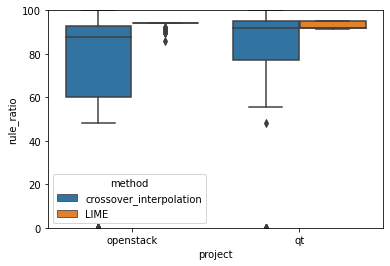

In [265]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_qt_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

In [264]:
print('Count unique value of LIME in openstack')
print(Counter(list(openstack_result_df[openstack_result_df['method']=='LIME']['rule_ratio'])))
print('Count unique value of LIME in qt')
print(Counter(list(qt_result_df[qt_result_df['method']=='LIME']['rule_ratio'])))

Count unique value of LIME in openstack
Counter({94.24989191526156: 170, 91.97038724373576: 13, 90.00370233246946: 9, 90.0: 4, 85.73167021600243: 1, 89.39183560122189: 1})
Count unique value of LIME in qt
Counter({95.28835540838853: 36, 91.8340927920464: 32, 91.50340868317188: 8, 91.91956706281834: 3})


,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,78.571429
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,90.236686
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,86.599852
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,90.236686
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,70.465686


<AxesSubplot:xlabel='project', ylabel='rule_ratio'>

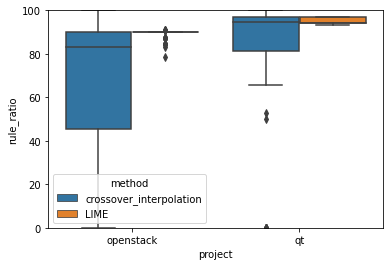

In [266]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_openstack_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_qt_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())
plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

In [134]:
print('Count unique value of LIME in openstack')
print(Counter(list(openstack_result_df[openstack_result_df['method']=='LIME']['rule_ratio'])))
print('Count unique value of LIME in qt')
print(Counter(list(qt_result_df[qt_result_df['method']=='LIME']['rule_ratio'])))

Count unique value of LIME in openstack
Counter({0.6210640608034745: 170, 0.7274569402228976: 13, 0.7716701902748414: 9, 0.8326650628174285: 4, 0.9733700642791552: 1, 0.8533178114086146: 1})
Count unique value of LIME in qt
Counter({0.8561460010735373: 36, 0.0: 32, 0.9674556213017752: 8, 0.8777777777777778: 3})


In [108]:
x_train, x_test, y_train, y_test = prepare_data('openstack', mode = 'all')
train_df = x_train.copy()
train_df['label'] = y_train

In [109]:
display(train_df[train_df['la']>58])

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr,label
commit_id,,,,,,,,,,,,,,
0d54770ee109bc7d598539b9238affdd1880997b,275,5,1,0.583216,3.0,1.729734,0,25.0,0.097581,2.0,272.0,0.114187,0.681661,False
5335b4ab0ef1f91203905764de6fcc7e53cb2934,288,7,2,0.648361,11.0,21.868067,0,30.0,0.116418,2.0,131.0,0.003413,0.327645,False
f3a9665e4349160fba08a09b846a773f4e785ba4,76,1,1,0.000000,5.0,-547.903623,0,11.0,1.902905,2.0,16.0,0.230769,0.307692,False
f53fb7705a48fb55de6547234a6937fc69a6e35b,1776,6,1,0.623152,6.0,-573.375440,0,2.0,16.391045,1.0,17.0,0.200000,0.550000,False
c77571e9199c756825d6805e5cb916973c010b64,272,2,1,0.154577,1.0,0.179028,0,21.0,0.798113,2.0,266.0,0.089701,0.621262,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77b23d6355d76a90610698ba06f4980c50ea84a0,72,1,1,0.000000,3.0,1.724039,0,0.0,0.000000,3.0,324.0,0.001217,0.358881,True
b0353599524121439878f10323c7482070523a39,64,5,1,0.852007,5.0,63.036285,0,33.0,16.028571,4.0,2803.0,0.000356,0.394549,False
70d1ec67c19b1e7639c8bf658cb40a65878875a1,65,2,1,0.935941,2.0,1.499549,0,4.0,44.199653,2.0,811.0,0.004860,0.889429,True


In [235]:

#         print(tok)
        
print(flip_rule('rtime > 40.69499969482422 & app > 2.0299999713897705 & nd <= 8.055000305175781'))
# flip_rule('rrexp < 849.4200134277344 & app >= 2.0049999952316284 & app <= 4.71999979019165')

print(flip_rule('la > 58'))
print(flip_rule('haha <= 58'))
print(flip_rule('0.63 < ent <= 0.86'))
print(flip_rule('self=0'))

rtime <= 40.69499969482422 and app <= 2.0299999713897705 and nd > 8.055000305175781 
la <= 58 
haha > 58 
0.63 >= ent or ent > 0.86 
self != 0 


In [231]:
# print(eval('0.63 < ent <= 0.86',{'ent':0.7}))
# print(eval('0.63 >= ent > 0.86', {'ent':0.9}))
# ent = 0.7
# if 0.63 < ent <= 0.86:
#     print('haha')
found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', '0.63 < ent <= 0.86')

print(found_rule)

found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', '0.63 <= ent < 0.86')
print(found_rule)

# found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', 'rrexp < 849.4200134277344 & app < 2.0049999952316284 & app <= 4.71999979019165')
# print(found_rule)

# found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', 'la <= 58')
# print(found_rule)

if len(found_rule) > 0:
    found_rule = found_rule[0]
    
var_in_rule = re.findall('[a-zA-Z]+',found_rule)

if len(found_rule) > 0:
    var_in_rule = var_in_rule[0]
    
# print(found_rule)
splitted_rule = found_rule.split(var_in_rule)
print(splitted_rule)
splitted_rule[0] = splitted_rule[0] + var_in_rule
splitted_rule[1] = var_in_rule + splitted_rule[1]
print(splitted_rule)
new_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
print(new_rule)
print(flip_rule(new_rule))
# print(eval(flip_rule(new_rule), {'ent':0.7}))

['0.63 < ent <= 0.86']
['0.63 <= ent < 0.86']
['0.63 <= ', ' < 0.86']
['0.63 <= ent', 'ent < 0.86']
0.63 <= ent or ent < 0.86
0.63 > ent or ent >= 0.86 
